In [ ]:
MODEL_PATH      = r"C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\SAM_models\sam_vit_b_01ec64.pth"
IMAGE_PATH      = r"C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\Images\Original_Img.jpg"
STROKES_PATH    = r"C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\Images\Strokes.json" 

import  numpy as np
import  cv2
import  matplotlib.pyplot as plt
import  json
from    segment_anything import sam_model_registry, SamAutomaticMaskGenerator



In [9]:
# Full image automatic masks detection

# Load SAM Model - using the ViT-B SAM model 
DEVICE = "cpu" 
sam    = sam_model_registry["vit_b"](checkpoint=MODEL_PATH).to(DEVICE)

# Create an automatic mask generator 
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side         = 16,  
    pred_iou_thresh         = 0.85, 
    stability_score_thresh  = 0.9,
    min_mask_region_area    = 1000
)

# Load and prepare an image - BGR to RGB
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate masks
masks = mask_generator.generate(image)

In [ ]:
# Save image with masks on top
def save_anns(image, anns, output_path="overlay_image.png"):
    if len(anns) == 0:
        print("No annotations to save.")
        return

    # Sort annotations by area (largest first)
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)

    # Create an RGBA image for overlay (same size as original)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], 
                   sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0  # Set full transparency initially

    # Apply sorted masks with random colors
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])  # RGBA color (semi-transparent)
        img[m] = color_mask  # Apply color to mask area

    # Convert mask overlay to 3-channel BGR image for OpenCV
    mask_overlay = (img[:, :, :3] * 255).astype(np.uint8)  # RGB mask
    alpha_mask = img[:, :, 3]  # Alpha channel for transparency

    # Blend only where the mask is present
    for c in range(3):  # Apply alpha blending per channel (R, G, B)
        image[:, :, c] = (1 - alpha_mask) * image[:, :, c] + alpha_mask * mask_overlay[:, :, c]

    # Save the image
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving
    print(f"Saved overlay image to {output_path}")

save_anns(image, masks, r"C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\Images\SAM_Img.jpg")

In [ ]:
# Mask data
print("Total masks: ", len(masks))
print(masks[0].keys())

In [ ]:
# Visualize segmentation results from SAM github
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax          = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m           = ann['segmentation']
        color_mask  = np.concatenate([np.random.random(3), [0.35]])
        img[m]      = color_mask
    ax.imshow(img)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()

[INFO] Loaded image: C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\Images\Original_Img.jpg
[INFO] Image size: width=2048, height=1536
[INFO] User mask size: (1536, 2048)
[INFO] User mask non-zero pixels: 156462


(np.float64(-0.5), np.float64(2047.5), np.float64(1535.5), np.float64(-0.5))

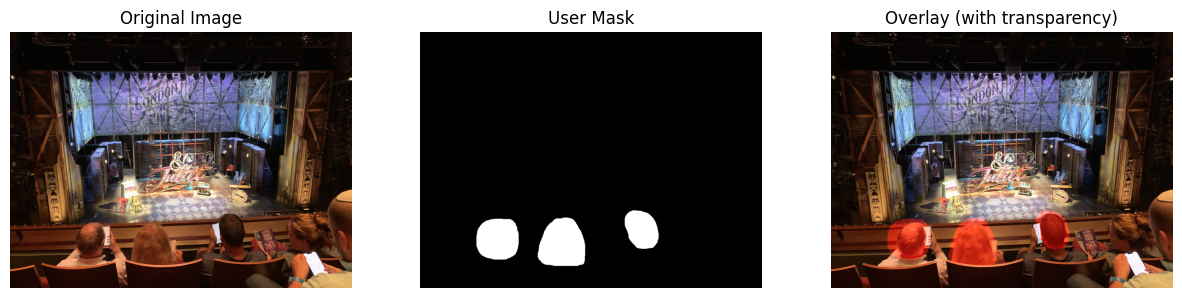

In [14]:
# User mask-processing
image                   = cv2.imread(IMAGE_PATH)
img_rgb                 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width   = image.shape[:2]

print(f"[INFO] Loaded image: {IMAGE_PATH}")
print(f"[INFO] Image size: width={img_width}, height={img_height}")

# Prepare blank mask
user_mask = np.zeros((img_height, img_width), dtype=np.uint8)

# Load strokes
with open(STROKES_PATH, "r") as f:
    strokes_data = json.load(f)

# Draw strokes on mask
for stroke in strokes_data:
    points = np.array([[int(p["x"]), int(p["y"])] for p in stroke["points"]], dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    cv2.fillPoly(user_mask, [points], color=1)

# Optionally fill
user_mask = cv2.dilate(user_mask, np.ones((3, 3), np.uint8), iterations=1)
user_mask = cv2.morphologyEx(user_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
user_mask = (user_mask > 0).astype(np.uint8)

print(f"[INFO] User mask size: {user_mask.shape}")
print(f"[INFO] User mask non-zero pixels: {np.count_nonzero(user_mask)}")

# ----- Visualization -----
plt.figure(figsize=(15, 5))

# 1. Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_rgb)
plt.axis("off")

# 2. User Mask
plt.subplot(1, 3, 2)
plt.title("User Mask")
plt.imshow(user_mask, cmap="gray")
plt.axis("off")

# 3. Overlay
# Create a red-colored mask (3 channels)
red_mask = np.zeros_like(img_rgb)
red_mask[user_mask == 1] = [255, 0, 0]  # Red

# Blend with transparency (alpha: 0.4)
alpha = 0.4
overlay = cv2.addWeighted(img_rgb, 1.0, red_mask, alpha, 0)

# Plot it
plt.subplot(1, 3, 3)
plt.title("Overlay (with transparency)")
plt.imshow(overlay)
plt.axis("off")



[INFO] Found 3 user-defined regions.
User Region 1: Best IoU = 0.6636 (SAM mask #0)


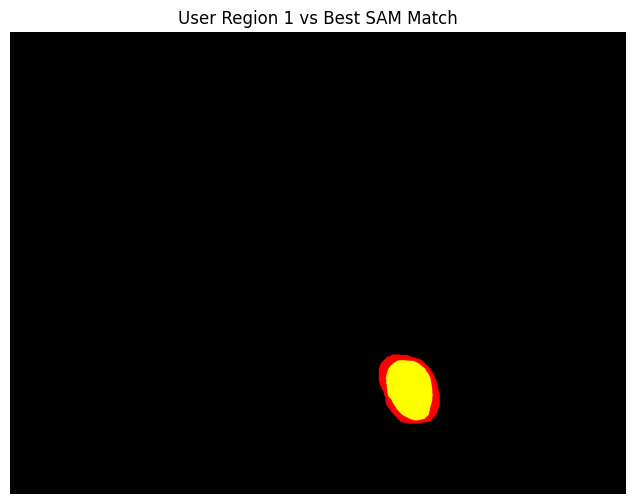

User Region 2: Best IoU = 0.7400 (SAM mask #1)


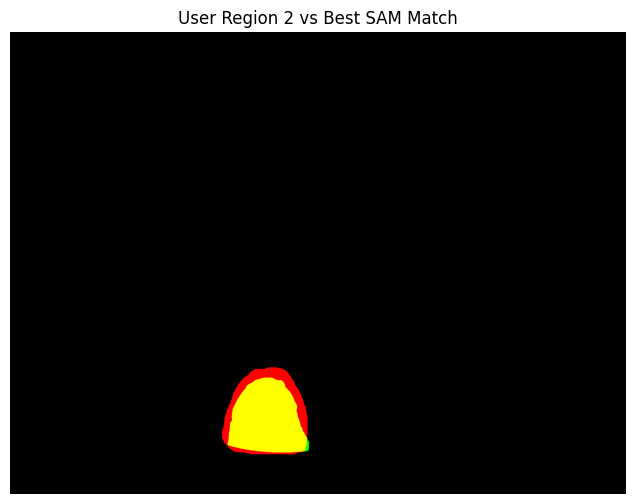

User Region 3: Best IoU = 0.4831 (SAM mask #4)


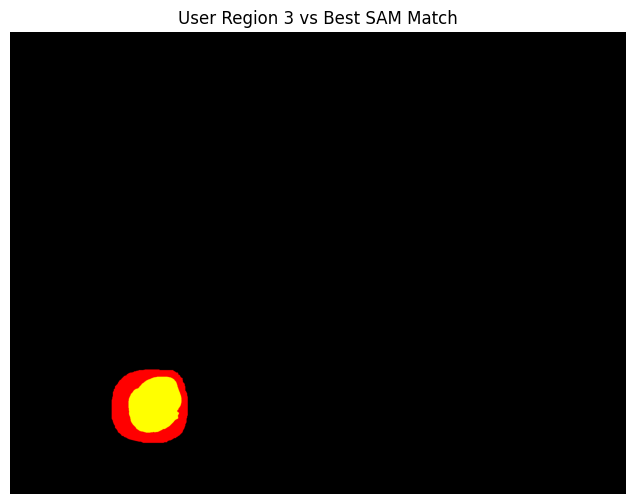

In [17]:
# User masks vs SAM segmentation
from skimage.measure import label, regionprops

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

def visualize_match(user_region_mask, sam_mask, region_id):
    # Create 3-color overlay:
    # Red       = user only
    # Green     = SAM only
    # Yellow    = overlap

    user_only = np.logical_and(user_region_mask == 1, sam_mask == 0)
    sam_only  = np.logical_and(user_region_mask == 0, sam_mask == 1)
    both      = np.logical_and(user_region_mask == 1, sam_mask == 1)

    overlay = np.zeros((*user_region_mask.shape, 3), dtype=np.uint8)
    overlay[user_only] = [255, 0, 0]     # Red
    overlay[sam_only]  = [0, 255, 0]     # Green
    overlay[both]      = [255, 255, 0]   # Yellow

    plt.figure(figsize=(8, 6))
    plt.title(f"User Region {region_id+1} vs Best SAM Match")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

# Step 1: Label connected components in user mask
user_labeled    = label(user_mask)  # This gives labels like 0,1,2,3 (0 is background)
num_regions     = np.max(user_labeled)
print(f"[INFO] Found {num_regions} user-defined regions.")

user_masks = [(user_labeled == i).astype(np.uint8) for i in range(1, num_regions + 1)]

# Convert all SAM masks to binary masks
sam_binary_masks = [m["segmentation"].astype(np.uint8) for m in masks]

# Match each user-drawn object to the best SAM mask
for i, u_mask in enumerate(user_masks):
    best_iou = 0
    best_idx = -1
    for j, s_mask in enumerate(sam_binary_masks):
        # Resize SAM mask if needed
        if s_mask.shape != u_mask.shape:
            s_mask = cv2.resize(s_mask, (u_mask.shape[1], u_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        iou = compute_iou(u_mask, s_mask)
        if iou > best_iou:
            best_iou = iou
            best_idx = j

    print(f"User Region {i+1}: Best IoU = {best_iou:.4f} (SAM mask #{best_idx})")

    # Visualize
    visualize_match(u_mask, sam_binary_masks[best_idx], i)


In [ ]:
# Combine all best SAM matches and user regions
combined_user_mask = np.zeros_like(user_mask)
combined_sam_mask = np.zeros_like(user_mask)
ious = []

for i, u_mask in enumerate(user_masks):
    best_iou = 0
    best_idx = -1
    for j, s_mask in enumerate(sam_binary_masks):
        # Resize if needed
        if s_mask.shape != u_mask.shape:
            s_mask = cv2.resize(s_mask, (u_mask.shape[1], u_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        iou = compute_iou(u_mask, s_mask)
        if iou > best_iou:
            best_iou = iou
            best_idx = j

    best_sam = sam_binary_masks[best_idx]
    combined_user_mask = np.logical_or(combined_user_mask, u_mask)
    combined_sam_mask = np.logical_or(combined_sam_mask, best_sam)
    ious.append(best_iou)

avg_iou = sum(ious) / len(ious)
print(f"[INFO] Average IoU: {avg_iou:.4f}")

In [ ]:
# Red = User only, Green = SAM only, Yellow = overlap
user_only = np.logical_and(combined_user_mask == 1, combined_sam_mask == 0)
sam_only  = np.logical_and(combined_user_mask == 0, combined_sam_mask == 1)
both      = np.logical_and(combined_user_mask == 1, combined_sam_mask == 1)

overlay_mask = np.zeros_like(img_rgb)
overlay_mask[user_only] = [255, 0, 0]     # Red
overlay_mask[sam_only]  = [0, 255, 0]     # Green
overlay_mask[both]      = [255, 255, 0]   # Yellow

# Blend with original image
alpha = 0.4
final_overlay = cv2.addWeighted(img_rgb, 1.0, overlay_mask, alpha, 0)

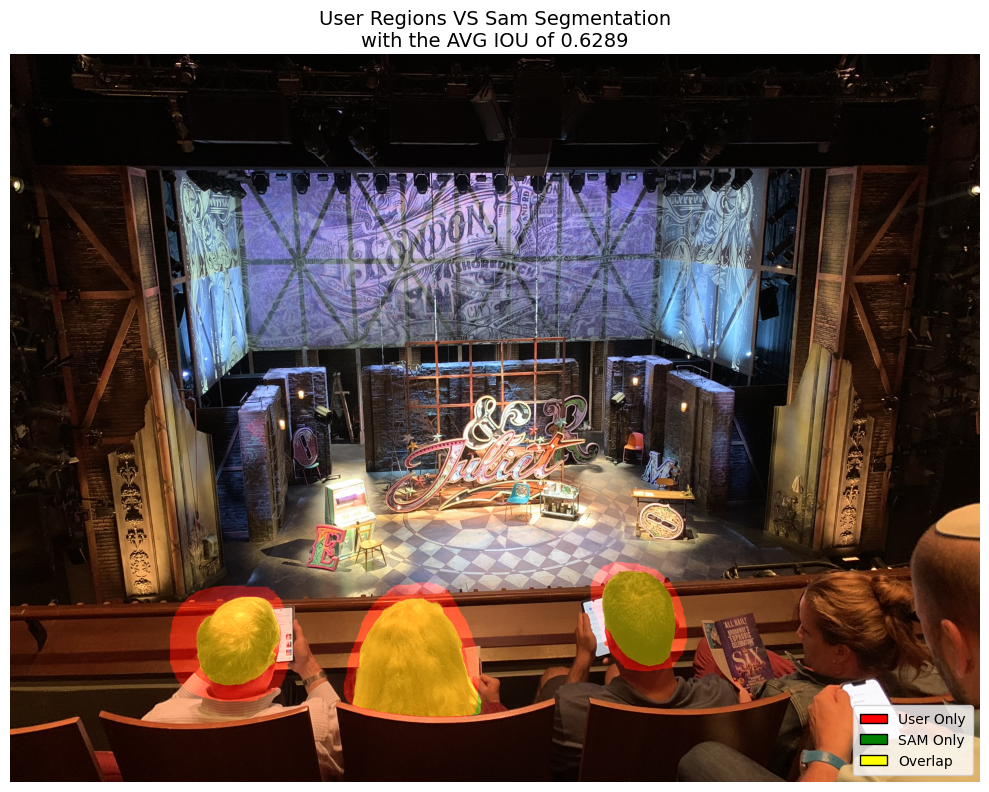

In [16]:
plt.figure(figsize=(10, 8))
plt.imshow(final_overlay)
plt.title(f"User Regions VS Sam Segmentation\nwith the AVG IOU of {avg_iou:.4f}", fontsize=14)
plt.axis("off")

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red',   edgecolor='black', label='User Only'),
    Patch(facecolor='green', edgecolor='black', label='SAM Only'),
    Patch(facecolor='yellow',edgecolor='black', label='Overlap'),
]
plt.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=10, borderpad=0.5)

plt.tight_layout()
plt.show()
